In [1]:
# Import the Spark Context
sc = SparkContext.getOrCreate()

In [2]:
# Import Keras libraries for TensorFlow
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.optimizers import SGD
import time

Using TensorFlow backend.


In [3]:
# Increase available memory to store the numpy arrays
import os
memory = '10g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

In [4]:
# Create numpy arrays from MNIST csvs
import csv
import numpy as np
path = '/home/nyasarturk1/Downloads/'
train_imgs_p = (path + 'mnist_train.csv')
test_imgs_p = (path + 'mnist_test.csv')
# Test and training image labels
trn_lbls = []
tst_lbls = []

print('Getting training image labels...')
with open(train_imgs_p, 'r', newline='') as csv_file1:
    csv_reader1 = csv.reader(csv_file1, delimiter=',')
    for row in csv_reader1:
        trn_lbls.append(row[0])
csv_file1.close()
print('Getting testing image labels...')
with open(test_imgs_p, 'r', newline='') as csv_file2:
    csv_reader2 = csv.reader(csv_file2, delimiter=',')
    for row in csv_reader2:
        tst_lbls.append(row[0])
csv_file2.close()

print('Converting labels to numpy arrays...')
trn_lbls = np.array(trn_lbls)
tst_lbls = np.array(tst_lbls)

# Download image csvs and convert to numpy arrays for training and testing
print('Extracting image data...')
with open(train_imgs_p) as f:
    ncols = len(f.readline().split(','))
train_imgs = np.loadtxt(train_imgs_p,delimiter=',', usecols=range(1,ncols))
test_imgs = np.loadtxt(test_imgs_p,delimiter=',', usecols=range(1,ncols))

print('Data ready.')

Getting training image labels...
Getting testing image labels...
Converting labels to numpy arrays...
Extracting image data...
Data ready.


In [5]:
# Reshape arrays to 4-d inputs
train_imgs = train_imgs.reshape(train_imgs.shape[0], 28, 28, 1)
test_imgs = test_imgs.reshape(test_imgs.shape[0],28,28,1)
# Define input shape
input_shape = (28,28,1)

#Attempt normalization
print('Normalizing numpy arrays...')
train_imgs = train_imgs.astype('float32')
test_imgs = test_imgs.astype('float32')
train_imgs /=255
test_imgs /= 255
# Normalize testing set by training set mean & standard deviation
#and add small floating point constant to prevent division by 0.
x_mean = train_imgs.mean(axis=0)
train_imgs -= x_mean
x_std = train_imgs.std(axis=0)
train_imgs /= x_std + 1e-8
test_imgs -= x_mean
test_imgs /= x_std + 1e-8

Normalizing numpy arrays...


In [6]:
# Define and compile a Keras model; this model obtained from towardsdatascience.com
model = Sequential()
model.add(Conv2D(28,kernel_size=(3,3),input_shape=input_shape)) #Initial input layer is equal to pixel dimensions
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())  # Changes dimensional structure into single dimension
model.add(Dense(128, activation=tf.nn.relu)) #Hidden layer
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax)) #Final layer predicts & tf needs to be the size of the total classes

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
start_time = time.time()
# Execute traditional TensorFlow training on local system
model.fit(x=train_imgs,y=trn_lbls, epochs=10)
print("Traditional Keras NN training time --- %s seconds ---"%(time.time()-start_time))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 151s 3ms/step - loss: 0.2071 - acc: 0.9424
Epoch 2/10
60000/60000 [==============================] - 150s 2ms/step - loss: 0.1088 - acc: 0.9708
Epoch 3/10
60000/60000 [==============================] - 151s 3ms/step - loss: 0.0774 - acc: 0.9785
Epoch 4/10
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0671 - acc: 0.9814
Epoch 5/10
60000/60000 [==============================] - 140s 2ms/step - loss: 0.0555 - acc: 0.9854
Epoch 6/10
60000/60000 [==============================] - 152s 3ms/step - loss: 0.0516 - acc: 0.9859
Epoch 7/10
60000/60000 [==============================] - 153s 3ms/step - loss: 0.0460 - acc: 0.9877
Epoch 8/10
60000/60000 [==============================] - 

"\nwe want an input layer of 28x28 neurons (pixel dimensions), then a Dense layer of 300\n#neurons, then a Dense layer of 10 neurons to be the output layer.\nmodel = keras.Sequential([\n    # Input Layer\n    keras.layers.InputLayer(\n        input_shape=((28*28),)),\n    \n    # Hidden Layer\n    keras.layers.Dense(300),\n    \n    #Final layer predicts\n    keras.layers.Dense(10, activation=tf.nn.softmax)\n    ])\n\nsgd = keras.optimizers.SGD(lr=0.0001,\n                           decay=1e-6,\n                           momentum=0.9,\n                           nesterov=True)\n\nmodel.compile(optimizer=sgd,\n              loss='sparse_categorical_crossentropy',\n              metrics=['accuracy']\n             )\n\n"

In [7]:
# Create RDDs from numpy arrays
from elephas.utils.rdd_utils import to_simple_rdd
rdd = to_simple_rdd(sc, train_imgs, trn_lbls)

WARNING


In [8]:
# Initialize SparkModel by passing in our Keras model
from elephas.spark_model import SparkModel
start_time = time.time()
spark_model = SparkModel(model, frequency='epoch', mode='asynchronous')
# Execute spark TensorFlow on dataset using parallel clusters
spark_model.fit(rdd, epochs=10, verbose=1, validation_split=0.1)
print("Spark NN training time --- %s seconds ---"%(time.time()-start_time))

 * Serving Flask app "elephas.parameter.server" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:4000/ (Press CTRL+C to quit)
127.0.0.1 - - [04/Mar/2019 02:14:17] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2019 02:14:19] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2019 02:16:20] "POST /update HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2019 02:16:20] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2019 02:16:23] "POST /update HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2019 02:16:23] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2019 02:18:20] "POST /update HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2019 02:18:20] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2019 02:18:24] "POST /update HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2019 02:18:24] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2019 02:20:20] "POST /update HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2019 02:20:20] "GET /parameters HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2019 02:20:26] "POST /update HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2019 02:20:26] "GET /paramet

Spark NN training time --- 1209.5768551826477 seconds ---


In [9]:
# Evaluate Spark model by evaluating the underlying model
score = spark_model.master_network.evaluate(test_imgs, tst_lbls, verbose=1)
print('Test accuracy:', score[1])

10000/10000 [==============================] - 6s 610us/step
Test accuracy: 0.9819


In [10]:
# Make predictions and output to csv
predictions = model.predict(test_imgs)
hi_con = []
hi_val = []
for p in range(len(predictions)):
    hi_con.append(np.argmax(predictions[p]))
    hi_val.append(max(predictions[p]))
csv_path = (path + 'predictions.csv')
with open(csv_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter = ',')
    #Write top row
    csv_writer.writerow(['Test image','Predicted Numeral','Correct?','Confidence'])
    for p in range(len(predictions)):
        # Get image number
        img_num = p
        # Get predicted digit
        pred_num = hi_con[p]
        # Check if correct
        if (int(tst_lbls[p])==int(pred_num)):
            cor = "Yes!"
        else:
            cor = "No!"
        val = hi_val[p]
        csv_writer.writerow([img_num,pred_num,cor,val])
csv_file.close()

In [48]:
# Visualize results
import matplotlib.pyplot as plt


with open(path+"predictions.csv", 'r', newline='') as csv_file3:
    csv_reader3 = csv.reader(csv_file3, delimiter=',')
    ns= [0,0,0,0,0,0,0,0,0,0]
    nws= [0,0,0,0,0,0,0,0,0,0] 
    cs= [0,0,0,0,0,0,0,0,0,0]
    acs= [0,0,0,0,0,0,0,0,0,0]
    tpr = [0,0,0,0,0,0,0,0,0,0]  # [number of instances correctly predicted by numeral, 
    #number of incorrect predictions by numeral, total confidence level by numeral, average confidence 
    #level by numeral, true positive rate]
    for row in csv_reader3:
        # If prediction is correct, add total confidence value by numeral and number of correct predictions
        if (row[2]=="Yes!"):
            ind = int(row[1])
            ns[ind] = ns[ind] + 1
            cs[ind] = cs[ind] + float(row[3])
        # If the prediction is incorrect, inrease num of incorrect prediction by numeral
        if((row[2]!="Yes!") and (row[2]!="Correct?")):
            ind = int(row[1])
            nws[ind] = nws[ind] + 1
    # Calculate average confidence value and true positive rate
    for i in range(10):
        acs[i] = cs[i]/ns[i]
        tpr[i] = ns[i]/(ns[i]+nws[i])
csv_file3.close()

# Plot both as bar graphs
label = ['0','1','2','3','4','5','6','7','8','9']
def plot_avg_conf():
    index = np.arange(len(label))
    plt.bar(index, acs)
    plt.xlabel('Numeral', fontsize=10)
    plt.ylabel('Average Confidence Rate', fontsize=10)
    plt.xticks(index, label, fontsize=10)
    plt.title('Average Confidence Rate By Numeral')
    plt.show()
    
def plot_tpr():
    index = np.arange(len(label))
    plt.bar(index, tpr)
    plt.xlabel('Numeral', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.xticks(index, label, fontsize=10)
    plt.title('True Positive Rate By Numeral')
    plt.show()
    
def mislabeled():
    index = np.arange(len(label))
    plt.bar(index, nws)
    plt.xlabel('Numeral', fontsize=10)
    plt.ylabel('Number Missed', fontsize=10)
    plt.xticks(index, label, fontsize=10)
    plt.title('Total Mislabeled Digits by Numeral')
    plt.show()


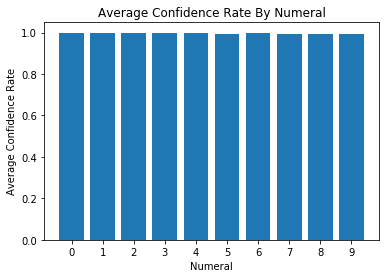

In [49]:
plot_avg_conf()

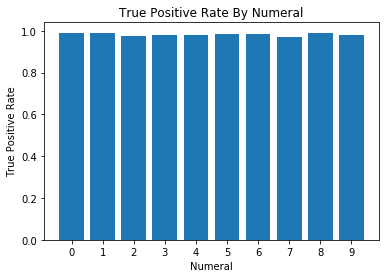

In [50]:
plot_tpr()

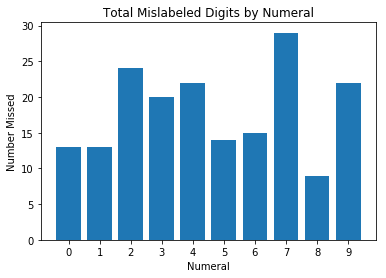

In [52]:
mislabeled()

In [53]:
'''
Write Up:

---What Does the Code Do?---
Given by both the MNIST Neural Network and MNIST Random Forest pdfs' comments.

---What Are the Goals of the Program?---
Both the former tutorial Random Forest program and current Neural Network program
aim to train a model to classify handwritten digits (taken in csv format in my case,
but originally given in .gz files; conversion would be possible, but csvs are far easier
to start out with) as 0-9.

---What Was Your Expected Result?---
I expected both in the Random Forest and the Neural Network to effectively classify 
numerals at a rate of over 90%. 

---What Issues Did You Face?---
Firstly, getting the images in a format easily manipulatable was problematic, but knowing 
a csv would make things simplest for me in tandum with python's csv module meant a simple
"MNIST as csv" Google search resolved this issue.

Normalization was then an issue, as for the NN to work, we had to normalize the testing set with
the training set's standard deviation and mean rather than its own. We also divided by 255
to resolve the pixel range and added a small floating point constant to prevent division by 0.

My Ubuntu system originally could not hold all the numpy arrays in memory with its small 5gb 
allocation, so I had to partition additional memory for that.

My original Neural Network topology (given by Out[6]) had a classfication rate of around 15%,
so I had to research the best possible NN topology for this classic dataset.

The test error rate calculation for the Random Forest given by the tutorial's code was incorrect,
so I had to correct that by referring to the documentation.

---Analysis of the Model I Used---
The Random Forest Model I used had a test set classification rate of 90.4%.
The Neural Network I originally used with topology:
1. Input Layer of 28*28
2. Hidden Dense Layer of 300 neurons
3. Output Dense Layer of 10 neurons
had a classification rate of about 15%; by using the NN from towardsdatascience.com,
I was able to achieve a classification rate of 98.19% with the Spark TensorFlow and 
similar classification rate for the traditional local TensorFlow, however the Spark
parallelized Keras TensorFlow processed about 5 minutes faster. I'd imagine that as 
the number of epochs increases, the training time difference between parallelized RDDs
and local numpy arrays will become exponentially larger.
While the Random Forest training and evaluation was slightly faster, it was less accurate.

---Analysis of the Predictions---
Given by the above graphs and similarly by Analysis of the Model I Used
section.

---How Could This Be Improved---
I could have deskewed the digits in order to further increase the classification rate.

'''

'\nWrite Up:\n\n---What Does the Code Do?---\nGiven by both the MNIST Neural Network and MNIST Random Forest pdfs\' comments.\n\n---What Are the Goals of the Program?---\nBoth the former tutorial Random Forest program and current Neural Network program\naim to train a model to classify handwritten digits (taken in csv format in my case,\nbut originally given in .gz files; conversion would be possible, but csvs are far easier\nto start out with) as 0-9.\n\n---What Was Your Expected Result?---\nI expected both in the Random Forest and the Neural Network to effectively classify \nnumerals at a rate of over 90%. \n\n---What Issues Did You Face?---\nFirstly, getting the images in a format easily manipulatable was problematic, but knowing \na csv would make things simplest for me in tandum with python\'s csv module meant a simple\n"MNIST as csv" Google search resolved this issue.\n\nNormalization was then an issue, as for the NN to work, we had to normalize the testing set with\nthe training